In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from datetime import time
import math
 
import xgboost as xgb
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn.base import BaseEstimator
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

In [ ]:

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.json to data.json
User uploaded file "data.json" with length 2134755 bytes


In [ ]:
data = next(iter(uploaded.values()))

In [ ]:

d = json.loads(data.decode())

In [ ]:
d[0]

{'_index': 'packets-2020-11-19',
 '_score': None,
 '_source': {'layers': {'eth': {'eth.dst': 'd8:32:e3:7a:8e:6b',
    'eth.dst_tree': {'eth.addr': 'd8:32:e3:7a:8e:6b',
     'eth.addr_resolved': 'XiaomiCo_7a:8e:6b',
     'eth.dst_resolved': 'XiaomiCo_7a:8e:6b',
     'eth.ig': '0',
     'eth.lg': '0'},
    'eth.src': '30:f7:72:0e:20:7f',
    'eth.src_tree': {'eth.addr': '30:f7:72:0e:20:7f',
     'eth.addr_resolved': 'HonHaiPr_0e:20:7f',
     'eth.ig': '0',
     'eth.lg': '0',
     'eth.src_resolved': 'HonHaiPr_0e:20:7f'},
    'eth.type': '0x00000800'},
   'frame': {'frame.cap_len': '74',
    'frame.coloring_rule.name': 'HTTP',
    'frame.coloring_rule.string': 'http || tcp.port == 80 || http2',
    'frame.encap_type': '1',
    'frame.ignored': '0',
    'frame.interface_id': '0',
    'frame.interface_id_tree': {'frame.interface_name': 'wlp19s0'},
    'frame.len': '74',
    'frame.marked': '0',
    'frame.number': '7',
    'frame.offset_shift': '0.000000000',
    'frame.protocols': 'eth:et

In [ ]:
columns_for_ip = ['ip.version', 'ip.hdr_len', 'ip.len', 'ip.id','ip.dsfield', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.checksum', 'ip.checksum.status', 'ip.src', 'ip.dst']

columns_for_frame = ['frame.interface_id','frame.time', 'frame.encap_type', 'frame.offset_shift', 'frame.time_epoch', 'frame.time_delta', 'frame.time_delta_displayed', 'frame.time_relative', 'frame.number', 'frame.len', 'frame.cap_len', 'frame.marked', 'frame.ignored']

columns_for_tcp = ['tcp.srcport', 'tcp.dstport', 'tcp.port', 'tcp.stream', 'tcp.len', 'tcp.seq', 'tcp.nxtseq', 'tcp.ack', 'tcp.hdr_len', 'tcp.flags', 'tcp.window_size_value', 'tcp.window_size', 'tcp.checksum', 'tcp.checksum.status']



In [ ]:
d[len(d)-1]["_source"]["layers"]["frame"]

{'frame.cap_len': '66',
 'frame.coloring_rule.name': 'TCP',
 'frame.coloring_rule.string': 'tcp',
 'frame.encap_type': '1',
 'frame.ignored': '0',
 'frame.interface_id': '0',
 'frame.interface_id_tree': {'frame.interface_name': 'wlp19s0'},
 'frame.len': '66',
 'frame.marked': '0',
 'frame.number': '259',
 'frame.offset_shift': '0.000000000',
 'frame.protocols': 'eth:ethertype:ip:tcp',
 'frame.time': 'Nov 19, 2020 14:14:36.838516459 IST',
 'frame.time_delta': '0.367890558',
 'frame.time_delta_displayed': '0.367890558',
 'frame.time_epoch': '1605775476.838516459',
 'frame.time_relative': '2.137991376'}

In [ ]:
def get_tcp_dict(d,i):
    tcp = {}
    for key,value in d[i]['_source']['layers']['tcp'].items():
      if key in columns_for_tcp:
        if key in ['tcp.checksum','tcp.flags']:
          tcp[key] = int(d[i]['_source']['layers']['tcp'][key],0)
          continue 
 
        if key not in ['tcp.checksum','tcp.flags','tcp.options']:
          tcp[key] = float(d[i]['_source']['layers']['tcp'][key])
        else:
          tcp[key] = d[i]['_source']['layers']['tcp'][key]
 
    return tcp

In [ ]:
def get_frame_dict(d,i):
    frame = {}
    for key,value in d[i]['_source']['layers']['frame'].items():
      if key in columns_for_frame:
        if key !="frame.time":
          frame[key] = float(d[i]['_source']['layers']['frame'][key])
        else:
          date_time = d[i]['_source']['layers']['frame'][key].split(" ")
          frame[key] = d[i]['_source']['layers']['frame'][key]
          frame["month"] = date_time[0]
          frame["year"] = int(date_time[2])
          v = pd.to_datetime(d[i]['_source']['layers']['frame'][key]).time()
          tme = time(v.hour,v.minute,v.second,int(str(v.microsecond)[:2]+"0000"))
          frame["hour"] = v.hour
          frame["minute"] = v.minute
          frame["second"] = v.second
          frame["microsecond"] = int(str(v.microsecond)[:2]+"0000")

    return frame


In [ ]:
def get_list_of_dict(d):
  all_features_dict= []

  for i in range(len(d)):
    tcp = get_tcp_dict(d,i)
      
    frame = get_frame_dict(d,i)

    ip = {}
    try:
      for key,value in d[i]['_source']['layers']['ip'].items():
        if key in columns_for_ip:
          if key in ['ip.checksum','ip.dsfield','ip.id','ip.flags']:
            ip[key] = int(d[i]['_source']['layers']['ip'][key],0)
          elif key not in ['ip.dst','ip.src']:
            ip[key] = int(d[i]['_source']['layers']['ip'][key])
          else:
            ip[key] = d[i]['_source']['layers']['ip'][key]

      ip.update(frame)
      ip.update(tcp)
      
      all_features_dict.append(ip)

    except:
      print("Not possible with index ",i)

  return all_features_dict




In [ ]:
df = pd.DataFrame(get_list_of_dict(d))
df

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Not possible with index  90
Not possible with index  96


,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,frame.time,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size_value,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.909431671 IST",Nov,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.950782064 IST",Nov,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,847,2.0
2,4,20,40,64,0,16384,59,6,10305,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:34.957032175 IST",Nov,2020,14,14,34,950000,0.0,1.605775e+09,0.006250,0.006250,0.256507,9.0,78.0,78.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,0.0,0.0,1.0,44.0,18,63443.0,63443.0,46189,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957103151 IST",Nov,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,502.0,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957559259 IST",Nov,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,502.0,64256.0,25770,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,4,20,40,477,10164,16384,59,6,25913,2,13.33.183.85,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:36.396606191 IST",Nov,2020,14,14,36,390000,0.0,1.605775e+09,0.001101,0.001101,1.696081,255.0,491.0,491.0,0.0,0.0,443.0,38282.0,38282.0,3.0,425.0,40.0,465.0,183.0,32.0,24,1073.0,1073.0,41818,2.0
245,4,20,0,52,42655,16384,64,6,58142,2,192.168.43.231,13.33.183.85,0.0,1.0,"Nov 19, 2020 14:14:36.396666712 IST",Nov,2020,14,14,36,390000,0.0,1.605775e+09,0.000061,0.000061,1.696142,256.0,66.0,66.0,0.0,0.0,38282.0,443.0,443.0,3.0,0.0,183.0,183.0,465.0,32.0,16,501.0,501.0,55672,2.0
246,4,20,0,87,42656,16384,64,6,58106,2,192.168.43.231,13.33.183.85,0.0,1.0,"Nov 19, 2020 14:14:36.397097184 IST",Nov,2020,14,14,36,390000,0.0,1.605775e+09,0.000430,0.000430,1.696572,257.0,101.0,101.0,0.0,0.0,38282.0,443.0,443.0,3.0,35.0,183.0,218.0,465.0,32.0,24,501.0,501.0,43483,2.0
247,4,20,40,52,4920,0,122,6,31838,2,13.33.183.85,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:36.470625901 IST",Nov,2020,14,14,36,470000,0.0,1.605775e+09,0.073529,0.073529,1.770101,258.0,66.0,66.0,0.0,0.0,443.0,38282.0,38282.0,3.0,0.0,465.0,465.0,218.0,32.0,16,1072.0,1072.0,55061,2.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ip.version                  249 non-null    int64  
 1   ip.hdr_len                  249 non-null    int64  
 2   ip.dsfield                  249 non-null    int64  
 3   ip.len                      249 non-null    int64  
 4   ip.id                       249 non-null    int64  
 5   ip.flags                    249 non-null    int64  
 6   ip.ttl                      249 non-null    int64  
 7   ip.proto                    249 non-null    int64  
 8   ip.checksum                 249 non-null    int64  
 9   ip.checksum.status          249 non-null    int64  
 10  ip.src                      249 non-null    object 
 11  ip.dst                      249 non-null    object 
 12  frame.interface_id          249 non-null    float64
 13  frame.encap_type            249 non

In [ ]:
mapping = {
    "Jan":1,
    "Feb":2,
    "Mar":3,
    "Apr":4,
    "May":5,
    "Jun":6,
    "Jul":7,
    "Aug":8,
    "Sep":9,
    "Oct":10,
    "Nov":11,
    "Dec":12
}

df["month"] = df["month"].map(mapping)
df.head()

,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,frame.time,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size_value,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.909431671 IST",11,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.950782064 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,847,2.0
2,4,20,40,64,0,16384,59,6,10305,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:34.957032175 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.006250,0.006250,0.256507,9.0,78.0,78.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,0.0,0.0,1.0,44.0,18,63443.0,63443.0,46189,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957103151 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,502.0,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957559259 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,502.0,64256.0,25770,2.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ip.version                  249 non-null    int64  
 1   ip.hdr_len                  249 non-null    int64  
 2   ip.dsfield                  249 non-null    int64  
 3   ip.len                      249 non-null    int64  
 4   ip.id                       249 non-null    int64  
 5   ip.flags                    249 non-null    int64  
 6   ip.ttl                      249 non-null    int64  
 7   ip.proto                    249 non-null    int64  
 8   ip.checksum                 249 non-null    int64  
 9   ip.checksum.status          249 non-null    int64  
 10  ip.src                      249 non-null    object 
 11  ip.dst                      249 non-null    object 
 12  frame.interface_id          249 non-null    float64
 13  frame.encap_type            249 non

In [ ]:
ch = df[df["ip.src"]=="192.168.43.231"]

In [ ]:
ch

,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,frame.time,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size_value,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.909431671 IST",11,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.950782064 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,847,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957103151 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,502.0,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957559259 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,502.0,64256.0,25770,2.0
5,4,20,0,1410,58033,16384,64,6,15221,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957698784 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000140,0.000140,0.257174,12.0,1424.0,1424.0,0.0,0.0,36420.0,80.0,80.0,0.0,1358.0,687.0,2045.0,1.0,32.0,16,502.0,64256.0,19310,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,4,20,0,52,58146,16384,64,6,16466,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:35.655462776 IST",11,2020,14,14,35,650000,0.0,1.605775e+09,0.000045,0.000045,0.954938,246.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,153008.0,153008.0,532.0,32.0,16,501.0,64128.0,36185,2.0
239,4,20,0,194,42653,16384,64,6,58002,2,192.168.43.231,13.33.183.85,0.0,1.0,"Nov 19, 2020 14:14:36.310792287 IST",11,2020,14,14,36,310000,0.0,1.605775e+09,0.577031,0.653970,1.610267,250.0,208.0,208.0,0.0,0.0,38282.0,443.0,443.0,3.0,142.0,2.0,144.0,1.0,32.0,24,501.0,501.0,14780,2.0
240,4,20,0,91,42654,16384,64,6,58104,2,192.168.43.231,13.33.183.85,0.0,1.0,"Nov 19, 2020 14:14:36.310896319 IST",11,2020,14,14,36,310000,0.0,1.605775e+09,0.000104,0.000104,1.610371,251.0,105.0,105.0,0.0,0.0,38282.0,443.0,443.0,3.0,39.0,144.0,183.0,1.0,32.0,24,501.0,501.0,25954,2.0
245,4,20,0,52,42655,16384,64,6,58142,2,192.168.43.231,13.33.183.85,0.0,1.0,"Nov 19, 2020 14:14:36.396666712 IST",11,2020,14,14,36,390000,0.0,1.605775e+09,0.000061,0.000061,1.696142,256.0,66.0,66.0,0.0,0.0,38282.0,443.0,443.0,3.0,0.0,183.0,183.0,465.0,32.0,16,501.0,501.0,55672,2.0


In [ ]:
all_dst = ch["ip.dst"].unique()

In [ ]:
all_dst

# 192.168.43.231 -->  52.209.245.238
# 192.168.43.231 --> 13.33.183.85


# all_dicts = [{"52.209.245.238": []}]

array(['52.209.245.238', '13.33.183.85'], dtype=object)

In [ ]:
def get_all_possible_dicts(all_dst):
  all_dicts = []
  for dst in all_dst:
    all_dicts.append({dst:[]})

  for i in range(len(df)):
    new_dict = {}
    dst = df.iloc[i]["ip.dst"]
    src = df.iloc[i]["ip.src"]
    for key,value in df.iloc[i].items():
      new_dict[key] = value 

    for i in range(len(all_dicts)):
      if list(all_dicts[i].keys())[0] == dst:
        all_dicts[i][dst].append(new_dict)
        break
      elif list(all_dicts[i].keys())[0]==src:
        all_dicts[i][src].append(new_dict)
        break
  return all_dicts
  


In [ ]:
all_dicts = get_all_possible_dicts(all_dst)

In [ ]:
all_dicts[0]["52.209.245.238"][1]

{'frame.cap_len': 74.0,
 'frame.encap_type': 1.0,
 'frame.ignored': 0.0,
 'frame.interface_id': 0.0,
 'frame.len': 74.0,
 'frame.marked': 0.0,
 'frame.number': 8.0,
 'frame.offset_shift': 0.0,
 'frame.time': 'Nov 19, 2020 14:14:34.950782064 IST',
 'frame.time_delta': 0.041350393,
 'frame.time_delta_displayed': 0.041350393,
 'frame.time_epoch': 1605775474.950782,
 'frame.time_relative': 0.250256981,
 'hour': 14,
 'ip.checksum': 1579,
 'ip.checksum.status': 2,
 'ip.dsfield': 0,
 'ip.dst': '52.209.245.238',
 'ip.flags': 16384,
 'ip.hdr_len': 20,
 'ip.id': 7490,
 'ip.len': 60,
 'ip.proto': 6,
 'ip.src': '192.168.43.231',
 'ip.ttl': 64,
 'ip.version': 4,
 'microsecond': 950000,
 'minute': 14,
 'month': 11,
 'second': 34,
 'tcp.ack': 0.0,
 'tcp.checksum': 847,
 'tcp.checksum.status': 2.0,
 'tcp.dstport': 80.0,
 'tcp.flags': 2,
 'tcp.hdr_len': 40.0,
 'tcp.len': 0.0,
 'tcp.nxtseq': 0.0,
 'tcp.port': 80.0,
 'tcp.seq': 0.0,
 'tcp.srcport': 36422.0,
 'tcp.stream': 1.0,
 'tcp.window_size': 64240.0

In [ ]:
len(all_dicts[0]['52.209.245.238'])

237

In [ ]:
len(all_dicts[1]['13.33.183.85'])

12

In [ ]:
len(df[(df["ip.dst"]=="52.209.245.238") | (df["ip.src"]=="52.209.245.238")])

237

In [ ]:
len(all_dicts[1]['13.33.183.85'])

12

In [ ]:
len(df[(df["ip.dst"]=='13.33.183.85') | (df["ip.src"]=='13.33.183.85')])

12

In [ ]:
def get_all_possible_dfs(all_dicts):
  all_dfs = []

  for i in range(len(all_dicts)):
    all_dfs.append({list(all_dicts[i].keys())[0]: pd.DataFrame(all_dicts[i][list(all_dicts[i].keys())[0]])})

  return all_dfs

In [ ]:
all_dfs = get_all_possible_dfs(all_dicts)

In [ ]:
all_dfs[0]["52.209.245.238"]

,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,frame.time,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size_value,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.909431671 IST",11,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.950782064 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,847,2.0
2,4,20,40,64,0,16384,59,6,10305,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:34.957032175 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.006250,0.006250,0.256507,9.0,78.0,78.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,0.0,0.0,1.0,44.0,18,63443.0,63443.0,46189,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957103151 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,502.0,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,192.168.43.231,52.209.245.238,0.0,1.0,"Nov 19, 2020 14:14:34.957559259 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,502.0,64256.0,25770,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,4,20,40,52,41809,0,123,6,34043,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:35.283982051 IST",11,2020,14,14,35,280000,0.0,1.605775e+09,0.000006,0.000006,0.583457,241.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,152783.0,32.0,16,2920.0,186880.0,35346,2.0
233,4,20,40,52,41810,0,123,6,34042,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:35.283986414 IST",11,2020,14,14,35,280000,0.0,1.605775e+09,0.000004,0.000004,0.583461,242.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,153008.0,32.0,16,2943.0,188352.0,35097,2.0
234,4,20,40,52,61304,0,123,6,14548,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:35.556080280 IST",11,2020,14,14,35,550000,0.0,1.605775e+09,0.272094,0.272094,0.855555,243.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,153008.0,32.0,16,2966.0,189824.0,35074,2.0
235,4,20,40,583,13760,16384,60,6,61305,2,52.209.245.238,192.168.43.231,0.0,1.0,"Nov 19, 2020 14:14:35.655417767 IST",11,2020,14,14,35,650000,0.0,1.605775e+09,0.059258,0.059258,0.954893,245.0,597.0,597.0,0.0,0.0,80.0,36420.0,36420.0,0.0,531.0,1.0,532.0,153008.0,32.0,24,2989.0,191296.0,57952,2.0


In [ ]:
all_dfs[0]["52.209.245.238"]["tcp.window_size"].unique()

array([ 64240.,  63443.,  64256.,  23360.,  24832.,  26304.,  27776.,
        29248.,  30720.,  32128.,  33600.,  35072.,  36544.,  38016.,
        39424.,  40896.,  42368.,  43840.,  45312.,  46720.,  48192.,
        49664.,  51136.,  52608.,  54080.,  55488.,  56960.,  58432.,
        59904.,  61376.,  62784.,  65728.,  67200.,  68672.,  70080.,
        71552.,  73024.,  74496.,  75968.,  77440.,  78848.,  80320.,
        81792.,  83264.,  84736.,  86144.,  87616.,  89088.,  90560.,
        92032.,  93440.,  94912.,  96384.,  97856.,  99328., 100800.,
       102208., 103680., 105152., 106624., 108096., 109504., 110976.,
       112448., 113920., 115392., 116800., 118272., 119744., 121216.,
       122688., 124160., 125568., 127040., 128512., 129984., 131456.,
       132864., 134336., 135808., 137280., 138752., 140160., 141632.,
       143104., 144576., 146048., 147520., 148928., 150400., 151872.,
       153344., 154816., 156224., 157696., 159168., 160640., 162112.,
       163520., 1649

In [ ]:
df[((df["ip.src"]=="192.168.43.231") | (df["ip.dst"]=="192.168.43.231")) & ( (df["ip.src"]=="52.209.245.238") | (df["ip.dst"]=="52.209.245.238"))]["tcp.window_size"].unique()

array([ 64240.,  63443.,  64256.,  23360.,  24832.,  26304.,  27776.,
        29248.,  30720.,  32128.,  33600.,  35072.,  36544.,  38016.,
        39424.,  40896.,  42368.,  43840.,  45312.,  46720.,  48192.,
        49664.,  51136.,  52608.,  54080.,  55488.,  56960.,  58432.,
        59904.,  61376.,  62784.,  65728.,  67200.,  68672.,  70080.,
        71552.,  73024.,  74496.,  75968.,  77440.,  78848.,  80320.,
        81792.,  83264.,  84736.,  86144.,  87616.,  89088.,  90560.,
        92032.,  93440.,  94912.,  96384.,  97856.,  99328., 100800.,
       102208., 103680., 105152., 106624., 108096., 109504., 110976.,
       112448., 113920., 115392., 116800., 118272., 119744., 121216.,
       122688., 124160., 125568., 127040., 128512., 129984., 131456.,
       132864., 134336., 135808., 137280., 138752., 140160., 141632.,
       143104., 144576., 146048., 147520., 148928., 150400., 151872.,
       153344., 154816., 156224., 157696., 159168., 160640., 162112.,
       163520., 1649

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ip.version                  249 non-null    int64  
 1   ip.hdr_len                  249 non-null    int64  
 2   ip.dsfield                  249 non-null    int64  
 3   ip.len                      249 non-null    int64  
 4   ip.id                       249 non-null    int64  
 5   ip.flags                    249 non-null    int64  
 6   ip.ttl                      249 non-null    int64  
 7   ip.proto                    249 non-null    int64  
 8   ip.checksum                 249 non-null    int64  
 9   ip.checksum.status          249 non-null    int64  
 10  ip.src                      249 non-null    object 
 11  ip.dst                      249 non-null    object 
 12  frame.interface_id          249 non-null    float64
 13  frame.encap_type            249 non

In [ ]:
mapping_for_src = {
    "192.168.43.231": 1,
    "52.209.245.238":0
}

act_df = all_dfs[0]["52.209.245.238"]
act_df["ip.src"] = act_df["ip.src"].map(mapping_for_src)
act_df["ip.dst"] = act_df["ip.dst"].map(mapping_for_src)

act_df.head()


,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,frame.time,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size_value,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,1,0,0.0,1.0,"Nov 19, 2020 14:14:34.909431671 IST",11,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,1,0,0.0,1.0,"Nov 19, 2020 14:14:34.950782064 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64240.0,847,2.0
2,4,20,40,64,0,16384,59,6,10305,2,0,1,0.0,1.0,"Nov 19, 2020 14:14:34.957032175 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.006250,0.006250,0.256507,9.0,78.0,78.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,0.0,0.0,1.0,44.0,18,63443.0,63443.0,46189,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,1,0,0.0,1.0,"Nov 19, 2020 14:14:34.957103151 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,502.0,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,1,0,0.0,1.0,"Nov 19, 2020 14:14:34.957559259 IST",11,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,502.0,64256.0,25770,2.0


In [ ]:
act_df = act_df.drop(["frame.time","tcp.window_size_value"],axis=1)
act_df.head()

,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,1,0,0.0,1.0,11,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,1,0,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,847,2.0
2,4,20,40,64,0,16384,59,6,10305,2,0,1,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.006250,0.006250,0.256507,9.0,78.0,78.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,0.0,0.0,1.0,44.0,18,63443.0,46189,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,1,0,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,1,0,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,64256.0,25770,2.0


In [ ]:
act_df

,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size,tcp.checksum,tcp.checksum.status
0,4,20,0,60,58030,16384,64,6,16574,2,1,0,0.0,1.0,11,2020,14,14,34,900000,0.0,1.605775e+09,0.000634,0.000000,0.208907,7.0,74.0,74.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,64007,2.0
1,4,20,0,60,7490,16384,64,6,1579,2,1,0,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.041350,0.041350,0.250257,8.0,74.0,74.0,0.0,0.0,36422.0,80.0,80.0,1.0,0.0,0.0,0.0,0.0,40.0,2,64240.0,847,2.0
2,4,20,40,64,0,16384,59,6,10305,2,0,1,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.006250,0.006250,0.256507,9.0,78.0,78.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,0.0,0.0,1.0,44.0,18,63443.0,46189,2.0
3,4,20,0,52,58031,16384,64,6,16581,2,1,0,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.000071,0.000071,0.256578,10.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,1.0,1.0,1.0,32.0,16,64256.0,60050,2.0
4,4,20,0,738,58032,16384,64,6,15894,2,1,0,0.0,1.0,11,2020,14,14,34,950000,0.0,1.605775e+09,0.000456,0.000456,0.257034,11.0,752.0,752.0,0.0,0.0,36420.0,80.0,80.0,0.0,686.0,1.0,687.0,1.0,32.0,24,64256.0,25770,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,4,20,40,52,41809,0,123,6,34043,2,0,1,0.0,1.0,11,2020,14,14,35,280000,0.0,1.605775e+09,0.000006,0.000006,0.583457,241.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,152783.0,32.0,16,186880.0,35346,2.0
233,4,20,40,52,41810,0,123,6,34042,2,0,1,0.0,1.0,11,2020,14,14,35,280000,0.0,1.605775e+09,0.000004,0.000004,0.583461,242.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,153008.0,32.0,16,188352.0,35097,2.0
234,4,20,40,52,61304,0,123,6,14548,2,0,1,0.0,1.0,11,2020,14,14,35,550000,0.0,1.605775e+09,0.272094,0.272094,0.855555,243.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,153008.0,32.0,16,189824.0,35074,2.0
235,4,20,40,583,13760,16384,60,6,61305,2,0,1,0.0,1.0,11,2020,14,14,35,650000,0.0,1.605775e+09,0.059258,0.059258,0.954893,245.0,597.0,597.0,0.0,0.0,80.0,36420.0,36420.0,0.0,531.0,1.0,532.0,153008.0,32.0,24,191296.0,57952,2.0


In [ ]:
def get_df_folds(act_df):
  act_df["kfold"] = -1
  act_df = act_df.sample(frac=1).reset_index(drop=True)
  kf = model_selection.StratifiedKFold(n_splits=5)

  for f, (t_, v_) in enumerate(kf.split(X=act_df, y=act_df["tcp.window_size"].values)):
    act_df.loc[v_, 'kfold'] = f

  return act_df


In [ ]:
act_df = get_df_folds(act_df)
act_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,ip.version,ip.hdr_len,ip.dsfield,ip.len,ip.id,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.checksum.status,ip.src,ip.dst,frame.interface_id,frame.encap_type,month,year,hour,minute,second,microsecond,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.number,frame.len,frame.cap_len,frame.marked,frame.ignored,tcp.srcport,tcp.dstport,tcp.port,tcp.stream,tcp.len,tcp.seq,tcp.nxtseq,tcp.ack,tcp.hdr_len,tcp.flags,tcp.window_size,tcp.checksum,tcp.checksum.status,kfold
0,4,20,0,52,58146,16384,64,6,16466,2,1,0,0.0,1.0,11,2020,14,14,35,650000,0.0,1.605775e+09,0.000045,0.000045,0.954938,246.0,66.0,66.0,0.0,0.0,36420.0,80.0,80.0,0.0,0.0,153008.0,153008.0,532.0,32.0,16,64128.0,36185,2.0,0
1,4,20,40,52,31494,0,123,6,44358,2,0,1,0.0,1.0,11,2020,14,14,35,170000,0.0,1.605775e+09,0.000040,0.000040,0.478150,170.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,84883.0,32.0,16,113920.0,39044,2.0,1
2,4,20,40,52,37880,0,123,6,37972,2,0,1,0.0,1.0,11,2020,14,14,35,230000,0.0,1.605775e+09,0.011322,0.011322,0.537646,226.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,132413.0,32.0,16,164992.0,56134,2.0,2
3,4,20,40,52,34341,0,123,6,41511,2,0,1,0.0,1.0,11,2020,14,14,35,190000,0.0,1.605775e+09,0.000017,0.000017,0.498536,183.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,94389.0,32.0,16,124160.0,29337,2.0,3
4,4,20,40,52,19038,0,123,6,56814,2,0,1,0.0,1.0,11,2020,14,14,35,130000,0.0,1.605775e+09,0.001859,0.001859,0.312494,44.0,66.0,66.0,0.0,0.0,80.0,36420.0,36420.0,0.0,0.0,1.0,1.0,10193.0,32.0,16,33600.0,49778,2.0,4


In [ ]:
act_df["kfold"].value_counts()

1    48
0    48
4    47
3    47
2    47
Name: kfold, dtype: int64

In [ ]:
def get_params_hyper_xgb(act_df):
  param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }
  X = act_df.drop("tcp.window_size",axis = 1)

  y = act_df["tcp.window_size"].values

  xgb_model = xgb.XGBRegressor()

  gsearch = model_selection.GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)
  gsearch.fit(X.values,y)

  print(f"Best score: {gsearch.best_score_}")
  print(gsearch.best_params_)



In [ ]:
def get_params_hyper_rfr(act_df):

  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
  
  max_features = ['auto', 'sqrt']
  
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)
  
  min_samples_split = [2, 5, 10]
  
  min_samples_leaf = [1, 2, 4]
  
  bootstrap = [True, False]
  
  random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

  X = act_df.drop("tcp.window_size",axis = 1)

  y = act_df["tcp.window_size"].values

  rf = ensemble.RandomForestRegressor()
  rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=10, random_state=42, n_jobs = -1)

  rf_random.fit(X.values,y)

  print(f"Best score: {rf_random.best_score_}")
  print(rf_random.best_params_)


In [ ]:
def get_params_hyper_dtr(act_df):

  param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              } 

  X = act_df.drop("tcp.window_size",axis = 1)

  y = act_df["tcp.window_size"].values

  tree = DecisionTreeRegressor()

  tree_random = model_selection.RandomizedSearchCV(estimator = tree, param_distributions = param_grid, n_iter = 20, cv = 5, verbose=10, random_state=42, n_jobs = -1)

  tree_random.fit(X,y)

  print(f"Best score: {tree_random.best_score_}")
  print(tree_random.best_params_)



  


In [ ]:
get_params_hyper_rfr(act_df)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


Best score: 0.9964957083466166
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [ ]:
get_params_hyper_xgb(act_df)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.1min


Best score: 0.985685840583679
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.1min finished


In [ ]:
get_params_hyper_dtr(act_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0201s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0201s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0784s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1463s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    0.6s


Best score: 0.9541705764643715
{'min_samples_split': 40, 'min_samples_leaf': 20, 'max_leaf_nodes': 5, 'max_depth': 6, 'criterion': 'mse'}


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


In [ ]:
import time

def run_rfr(fold,act_df):

  df_train = act_df[act_df.kfold != fold].reset_index(drop=True)

  df_valid = act_df[act_df.kfold == fold].reset_index(drop=True)

  x_train = df_train.drop("tcp.window_size",axis = 1)

  x_train_act = df_train["tcp.window_size"].values

  x_valid = df_valid.drop("tcp.window_size",axis = 1)

  x_valid_act = df_valid["tcp.window_size"].values

  # {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}

  model = ensemble.RandomForestRegressor(
    n_estimators=600,
    max_depth=70,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    bootstrap=True,
    
  )

  start_time = time.time()
  model.fit(x_train.values,x_train_act)
  predictions = model.predict(x_valid.values)
  print("--- %s seconds ---" % (time.time() - start_time))
  
  plt.plot(predictions,c="r")
  plt.plot(x_valid_act,c="b")
  plt.show()
  # for (x,y) in zip(x_valid_act,predictions):
  #   print(f"{x} {y}")
  mae = metrics.mean_absolute_error(x_valid_act,predictions)
  mse = metrics.mean_squared_error(x_valid_act,predictions)
  rmse = math.sqrt(mse)
  msle = metrics.mean_squared_log_error(x_valid_act,predictions)
  rmsle = math.sqrt(msle)
  r2 = metrics.r2_score(x_valid_act,predictions)

  print("1) Mean absolute error "+ str(mae))
  print("2) Mean squared error " + str(mse))
  print("3) Root mean squared error " + str(rmse))
  print("4) mean squared log error " + str(msle))
  print("5) root mean squared log error " + str(rmsle))
  print("6) R2 score " + str(r2) + "\n")





--- 1.2647881507873535 seconds ---


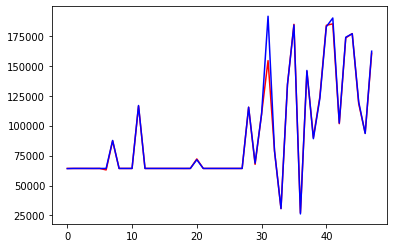

1) Mean absolute error 1186.0218402777787
2) Mean squared error 29393199.609071698
3) Root mean squared error 5421.5495579282215
4) mean squared log error 0.0010374903568096889
5) root mean squared log error 0.03221009712512039
6) R2 score 0.9845502801450254

--- 1.2965607643127441 seconds ---


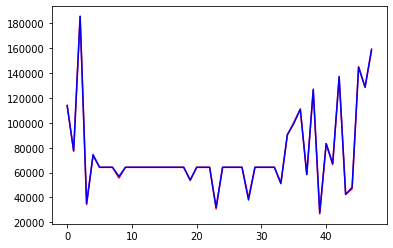

1) Mean absolute error 356.1445833333335
2) Mean squared error 375146.9754503471
3) Root mean squared error 612.4924288922657
4) mean squared log error 0.0001513668377350419
5) root mean squared log error 0.012303123088673132
6) R2 score 0.9996437406356795

--- 1.252577781677246 seconds ---


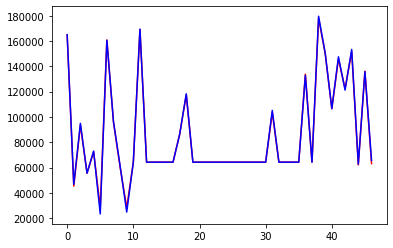

1) Mean absolute error 596.9245035460988
2) Mean squared error 1357390.7188378838
3) Root mean squared error 1165.0711217938087
4) mean squared log error 0.0012415394996395579
5) root mean squared log error 0.035235486368710135
6) R2 score 0.9990970363459256

--- 1.2696912288665771 seconds ---


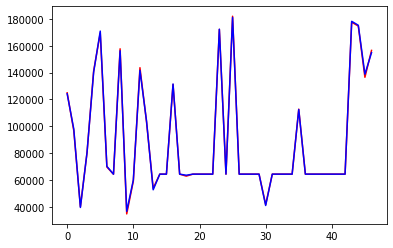

1) Mean absolute error 464.7570921985827
2) Mean squared error 610889.25529102
3) Root mean squared error 781.5940476302388
4) mean squared log error 0.00011257946960194341
5) root mean squared log error 0.01061034728941251
6) R2 score 0.9996564272758874

--- 1.2684297561645508 seconds ---


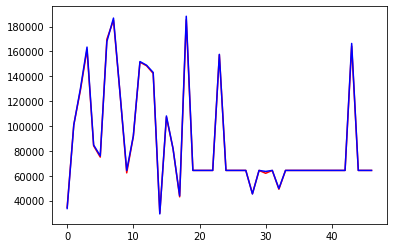

1) Mean absolute error 508.124539007093
2) Mean squared error 792344.9956647767
3) Root mean squared error 890.1376273727432
4) mean squared log error 9.628747089087285e-05
5) root mean squared log error 0.009812617942775152
6) R2 score 0.9995537869073293



In [ ]:
run_rfr(0,act_df)
run_rfr(1,act_df)
run_rfr(2,act_df)
run_rfr(3,act_df)
run_rfr(4,act_df)

In [ ]:
def run_xgb(fold,act_df):

  df_train = act_df[act_df.kfold != fold].reset_index(drop=True)

  df_valid = act_df[act_df.kfold == fold].reset_index(drop=True)

  x_train = df_train.drop("tcp.window_size",axis = 1)

  x_train_act = df_train["tcp.window_size"].values

  x_valid = df_valid.drop("tcp.window_size",axis = 1)

  x_valid_act = df_valid["tcp.window_size"].values

  # 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.5}

  model = xgb.XGBRegressor(
    n_estimators=200,
    colsample_bytree=0.7,
    max_depth=10,
    min_child_weight=3,
    learning_rate=0.1,
    subsample=0.5
    
  )
  
  start_time = time.time()
  model.fit(x_train.values,x_train_act)
  predictions = model.predict(x_valid.values)
  print("--- %s seconds ---" % (time.time() - start_time))

  plt.plot(predictions,c="r")
  plt.plot(x_valid_act,c="b")
  plt.show()
  # for (x,y) in zip(x_valid_act,predictions):
  #   print(f"{x} {y}")
  mae = metrics.mean_absolute_error(x_valid_act,predictions)
  mse = metrics.mean_squared_error(x_valid_act,predictions)
  rmse = math.sqrt(mse)
  msle = metrics.mean_squared_log_error(x_valid_act,predictions)
  rmsle = math.sqrt(msle)
  r2 = metrics.r2_score(x_valid_act,predictions)

  print("1) Mean absolute error "+ str(mae))
  print("2) Mean squared error " + str(mse))
  print("3) Root mean squared error " + str(rmse))
  print("4) mean squared log error " + str(msle))
  print("5) root mean squared log error " + str(rmsle))
  print("6) R2 score " + str(r2) + "\n")





[07:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- 0.13737034797668457 seconds ---


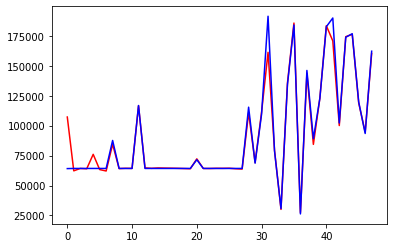

1) Mean absolute error 3003.6124267578125
2) Mean squared error 69921730.22277777
3) Root mean squared error 8361.921443231678
4) mean squared log error 0.007194947810021322
5) root mean squared log error 0.0848230382031988
6) R2 score 0.9632475824991975

[07:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- 0.13716840744018555 seconds ---


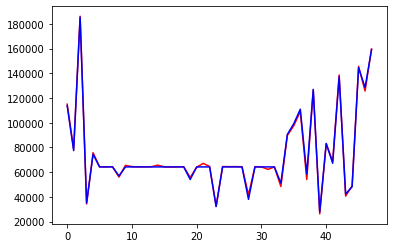

1) Mean absolute error 968.0726318359375
2) Mean squared error 1958751.8447374504
3) Root mean squared error 1399.5541592726772
4) mean squared log error 0.000654598116772717
5) root mean squared log error 0.02558511514089231
6) R2 score 0.9981398658852837

[07:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- 0.14387011528015137 seconds ---


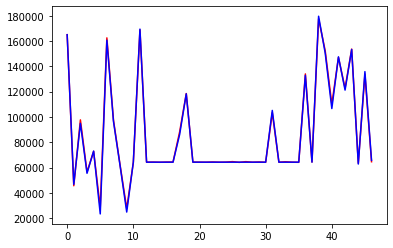

1) Mean absolute error 811.623670212766
2) Mean squared error 1777723.2753898134
3) Root mean squared error 1333.3128947811963
4) mean squared log error 0.0011186440705783045
5) root mean squared log error 0.03344613685582095
6) R2 score 0.9988174226606961

[07:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- 0.13968324661254883 seconds ---


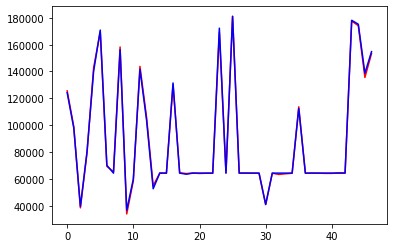

1) Mean absolute error 842.3612865691489
2) Mean squared error 1545337.5909654333
3) Root mean squared error 1243.1160810501299
4) mean squared log error 0.0002656205866144478
5) root mean squared log error 0.016297870615956177
6) R2 score 0.9991308803662806

[07:15:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- 0.14328503608703613 seconds ---


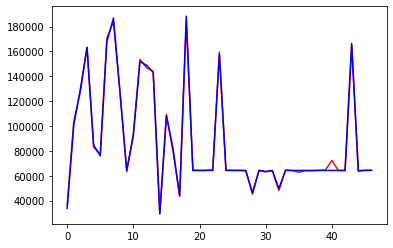

1) Mean absolute error 1171.5374833776596
2) Mean squared error 3478513.8818200296
3) Root mean squared error 1865.0774466010866
4) mean squared log error 0.0005753564677874187
5) root mean squared log error 0.023986589332112614
6) R2 score 0.9980410573101396



In [ ]:
run_xgb(0,act_df)
run_xgb(1,act_df)
run_xgb(2,act_df)
run_xgb(3,act_df)
run_xgb(4,act_df)

In [ ]:

def run_dtr(fold,act_df):

  df_train = act_df[act_df.kfold != fold].reset_index(drop=True)

  df_valid = act_df[act_df.kfold == fold].reset_index(drop=True)

  x_train = df_train.drop("tcp.window_size",axis = 1)

  x_train_act = df_train["tcp.window_size"].values

  x_valid = df_valid.drop("tcp.window_size",axis = 1)

  x_valid_act = df_valid["tcp.window_size"].values

  # {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': 5, 'max_depth': 8, 'criterion': 'mse'}

  model = DecisionTreeRegressor(
      min_samples_split=20,
      min_samples_leaf=20,
      max_leaf_nodes=5,
      max_depth=8
  )
  
  start_time = time.time()
  model.fit(x_train.values,x_train_act)
  predictions = model.predict(x_valid.values)
  print("--- %s seconds ---" % (time.time() - start_time))

  plt.plot(predictions,c="r")
  plt.plot(x_valid_act,c="b")
  plt.show()
  # for (x,y) in zip(x_valid_act,predictions):
  #   print(f"{x} {y}")
  mae = metrics.mean_absolute_error(x_valid_act,predictions)
  mse = metrics.mean_squared_error(x_valid_act,predictions)
  rmse = math.sqrt(mse)
  msle = metrics.mean_squared_log_error(x_valid_act,predictions)
  rmsle = math.sqrt(msle)
  r2 = metrics.r2_score(x_valid_act,predictions)

  print("1) Mean absolute error "+ str(mae))
  print("2) Mean squared error " + str(mse))
  print("3) Root mean squared error " + str(rmse))
  print("4) mean squared log error " + str(msle))
  print("5) root mean squared log error " + str(rmsle))
  print("6) R2 score " + str(r2) + "\n")





--- 0.0014379024505615234 seconds ---


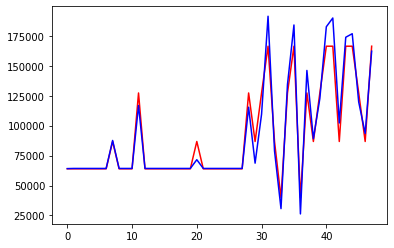

1) Mean absolute error 5809.528682081805
2) Mean squared error 86656384.53577907
3) Root mean squared error 9308.941107117344
4) mean squared log error 0.010416354080685988
5) root mean squared log error 0.10206054125217046
6) R2 score 0.954451475765519

--- 0.0018932819366455078 seconds ---


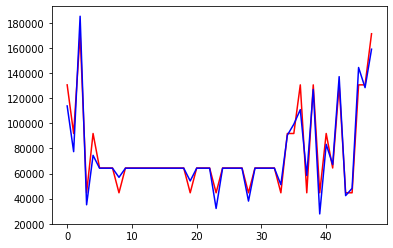

1) Mean absolute error 4969.874547101449
2) Mean squared error 62395041.1570946
3) Root mean squared error 7899.053181052435
4) mean squared log error 0.01615836618853455
5) root mean squared log error 0.12711556233811244
6) R2 score 0.9407463763430441

--- 0.004365444183349609 seconds ---


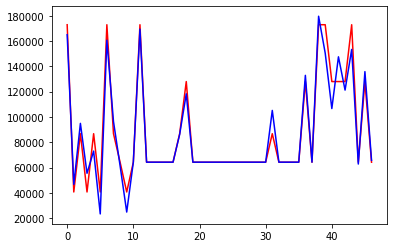

1) Mean absolute error 5398.947533298006
2) Mean squared error 79260383.3913976
3) Root mean squared error 8902.830077643715
4) mean squared log error 0.01844796720554103
5) root mean squared log error 0.1358232940461283
6) R2 score 0.9472743960768295

--- 0.0018496513366699219 seconds ---


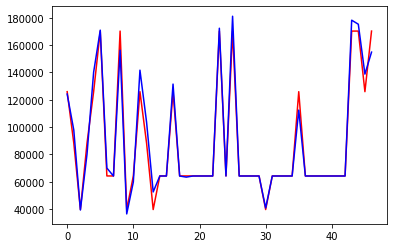

1) Mean absolute error 3875.077508361202
2) Mean squared error 44558599.49375789
3) Root mean squared error 6675.22280480269
4) mean squared log error 0.004620458316850398
5) root mean squared log error 0.06797395322364588
6) R2 score 0.9749396158499789

--- 0.0034494400024414062 seconds ---


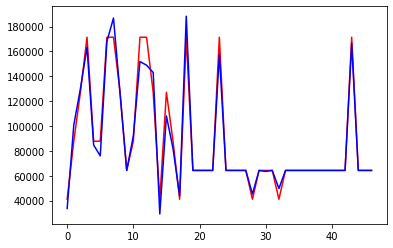

1) Mean absolute error 4639.564823195808
2) Mean squared error 63815679.754745
3) Root mean squared error 7988.471678283963
4) mean squared log error 0.007581131088585177
5) root mean squared log error 0.08706969098707756
6) R2 score 0.9640618771115497



In [ ]:
run_dtr(0,act_df)
run_dtr(1,act_df)
run_dtr(2,act_df)
run_dtr(3,act_df)
run_dtr(4,act_df)